##  Classification pipeline

### Last update: 8/24/19
### File: C:\Users\megan\OneDrive\Data_Analytics\C5T2_3\Credit default analysis.ipynb
### Project Name: Credit Default Analysis

In [77]:
#Import libraries and modules

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.tools as tls

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [78]:
#import data

#load train/existing data (dataset1)
credit = pd.read_csv('default of credit card clients.csv', header = 1)

#load predict/new data (dataset2)

### Data Pre-Processing

In [79]:
#check for missing data
print(credit.isnull().values.any())

False


In [80]:
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [81]:
credit.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [82]:
credit.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [83]:
credit['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [84]:
18112 / 30000

0.6037333333333333

In [85]:
11888 / 30000

0.39626666666666666

In [86]:
credit['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [87]:
23364 / 30000

0.7788

In [88]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

All variables are listed as integers in dataset. Need to change sex, education, and marriage to category after exploratory data analysis is done.

In [89]:
credit = credit.drop(columns=['ID'])

In [90]:
credit.rename(columns={"default payment next month": "default"}, inplace = True)

In [91]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [92]:
credit['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [93]:
#group education levels 4,5,6 into single group 4 
#NOTE for future analysis, it would help to understand what 4,5,6 are
credit['EDUCATION'] = credit['EDUCATION'].replace([4, 5, 6], 4)

In [94]:
#check recode
credit['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      454
0       14
Name: EDUCATION, dtype: int64

In [95]:
#check negative amounts for bill statements to see if they make sense
credit.nsmallest(10, 'BILL_AMT6')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
290,280000,1,1,2,33,-1,-1,-1,-1,-1,...,898,325,-339603,898,325,898,325,0,345293,1
26097,290000,2,2,1,33,-2,-1,0,0,0,...,17391,16348,-209051,17654,11068,7600,3352,6104,261883,0
12828,100000,2,1,2,25,2,2,-2,-2,-2,...,0,0,-150953,0,0,0,0,0,150400,0
29491,320000,1,1,2,31,1,-2,-2,-2,-2,...,-50616,-53007,-94625,185,28,12,208,8,14,1
28919,180000,2,1,1,40,0,-1,0,0,0,...,5698,5993,-73895,22864,1133,1000,1000,0,159000,0
27080,290000,1,1,2,38,-2,-2,-2,-2,-2,...,2278,1224,-57060,1827,2066,2287,1242,1827,60860,0
12388,450000,2,2,1,37,-1,-1,-1,-1,-1,...,783,1730,-51443,1032,2663,783,1730,0,70803,1
3525,140000,1,1,2,28,0,-1,-1,0,-1,...,4490,1500,-51183,4340,5491,2013,1510,18,89898,0
21235,150000,1,1,2,36,2,2,2,-2,-2,...,-46627,-46627,-46627,5068,9,0,0,0,0,1
5548,260000,2,2,2,26,0,0,0,0,-1,...,62373,746,-45734,7000,5115,2000,746,5025,54836,0


In [96]:
#check outliers - done with EDA below

In [97]:
#several rows with 0's across payment amt and bill amt. check how many
zero = (credit[(credit.PAY_AMT1 == 0) & (credit.PAY_AMT2 == 0) & (credit.PAY_AMT3 == 0) & (credit.PAY_AMT4 == 0) & \
             (credit.PAY_AMT5 == 0) & (credit.PAY_AMT6 == 0) & (credit.BILL_AMT1 ==0) & (credit.BILL_AMT2 ==0) & \
                   (credit.BILL_AMT3 == 0) & (credit.BILL_AMT4 == 0) & (credit.BILL_AMT5 == 0) & (credit.BILL_AMT6 == 0)])

In [98]:
print(zero.count())

LIMIT_BAL    795
SEX          795
EDUCATION    795
MARRIAGE     795
AGE          795
PAY_0        795
PAY_2        795
PAY_3        795
PAY_4        795
PAY_5        795
PAY_6        795
BILL_AMT1    795
BILL_AMT2    795
BILL_AMT3    795
BILL_AMT4    795
BILL_AMT5    795
BILL_AMT6    795
PAY_AMT1     795
PAY_AMT2     795
PAY_AMT3     795
PAY_AMT4     795
PAY_AMT5     795
PAY_AMT6     795
default      795
dtype: int64


There are a total of 795 rows where BOTH the bill amount and payment amount are zero. Let's make a new dataset where these rows are removed for later model metric comparison as it is not clear if these are missing values or true zero for bill/payments.

In [99]:
credit_zero = credit.drop(zero.index, axis=0)

In [100]:
credit_zero.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [101]:
credit_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29205 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    29205 non-null int64
SEX          29205 non-null int64
EDUCATION    29205 non-null int64
MARRIAGE     29205 non-null int64
AGE          29205 non-null int64
PAY_0        29205 non-null int64
PAY_2        29205 non-null int64
PAY_3        29205 non-null int64
PAY_4        29205 non-null int64
PAY_5        29205 non-null int64
PAY_6        29205 non-null int64
BILL_AMT1    29205 non-null int64
BILL_AMT2    29205 non-null int64
BILL_AMT3    29205 non-null int64
BILL_AMT4    29205 non-null int64
BILL_AMT5    29205 non-null int64
BILL_AMT6    29205 non-null int64
PAY_AMT1     29205 non-null int64
PAY_AMT2     29205 non-null int64
PAY_AMT3     29205 non-null int64
PAY_AMT4     29205 non-null int64
PAY_AMT5     29205 non-null int64
PAY_AMT6     29205 non-null int64
default      29205 non-null int64
dtypes: int64(24)
memory usage: 5.6 MB


In [102]:
#discretize age into 4 bins for both datasets
credit['AGE'] = pd.qcut(credit['AGE'],4)
credit['AGE'].value_counts()

(20.999, 28.0]    8013
(28.0, 34.0]      7683
(41.0, 79.0]      7450
(34.0, 41.0]      6854
Name: AGE, dtype: int64

In [103]:
credit_zero['AGE'] = pd.qcut(credit_zero['AGE'],4)
credit_zero['AGE'].value_counts()

(20.999, 28.0]    7857
(28.0, 34.0]      7452
(41.0, 79.0]      7230
(34.0, 41.0]      6666
Name: AGE, dtype: int64

In [104]:
#make new dataset with discretization for bill and payment amounts 
#plt.hist(credit['BILL_AMT1'])
credit_v1 = credit.copy()
#plt.show()
bins = pd.IntervalIndex.from_tuples([(-16558, 0), (0, 15000), (15000, 60000), (60000, 964511.0)])
credit_v1['BILL_AMT1'] = pd.cut(credit_v1['BILL_AMT1'],bins)
credit_v1['BILL_AMT1'].value_counts()

(0.0, 15000.0]         9889
(15000.0, 60000.0]     9331
(60000.0, 964511.0]    8182
(-16558.0, 0.0]        2596
Name: BILL_AMT1, dtype: int64

In [105]:
#plt.hist(credit['BILL_AMT2'])
#plt.show()
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-69777.001, 0), (0, 15000), (15000, 60000), (60000, 983931.0)])
credit_v1['BILL_AMT2'] = pd.cut(credit_v1['BILL_AMT2'],bins)
credit_v1['BILL_AMT2'].value_counts()

(0.0, 15000.0]         9508
(15000.0, 60000.0]     9411
(60000.0, 983931.0]    7906
(-69777.001, 0.0]      3175
Name: BILL_AMT2, dtype: int64

In [106]:
#plt.hist(credit['BILL_AMT3'])
#plt.show()
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-157264.001, 0), (0, 15000), (15000, 60000), (60000, 1664089.0)])
credit_v1['BILL_AMT3'] = pd.cut(credit_v1['BILL_AMT3'],bins)
credit_v1['BILL_AMT3'].value_counts()

(15000.0, 60000.0]      9657
(0.0, 15000.0]          9303
(60000.0, 1664089.0]    7515
(-157264.001, 0.0]      3525
Name: BILL_AMT3, dtype: int64

In [107]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-170000.001, 0), (0, 15000), (15000, 60000), (60000, 891586.0)])
#credit_v1['BILL_AMT4'] = pd.qcut(credit_v1['BILL_AMT4'],5)
credit_v1['BILL_AMT4'] = pd.cut(credit_v1['BILL_AMT4'],bins)
credit_v1['BILL_AMT4'].value_counts()

(15000.0, 60000.0]     9791
(0.0, 15000.0]         9416
(60000.0, 891586.0]    6923
(-170000.001, 0.0]     3870
Name: BILL_AMT4, dtype: int64

In [108]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-81334.001, 0), (0, 15000), (15000, 60000), (60000, 927171.0)])
#credit_v1['BILL_AMT5'] = pd.qcut(credit_v1['BILL_AMT5'],5)
credit_v1['BILL_AMT5'] = pd.cut(credit_v1['BILL_AMT5'],bins)
credit_v1['BILL_AMT5'].value_counts()

(15000.0, 60000.0]     9705
(0.0, 15000.0]         9670
(60000.0, 927171.0]    6464
(-81334.001, 0.0]      4161
Name: BILL_AMT5, dtype: int64

In [109]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-339603.001, 0), (0, 15000), (15000, 60000), (60000, 961664.0)])
#credit_v1['BILL_AMT6'] = pd.qcut(credit_v1['BILL_AMT6'],5)
credit_v1['BILL_AMT6'] = pd.cut(credit_v1['BILL_AMT6'],bins)
credit_v1['BILL_AMT6'].value_counts()

(0.0, 15000.0]         9594
(15000.0, 60000.0]     9455
(60000.0, 961664.0]    6243
(-339603.001, 0.0]     4708
Name: BILL_AMT6, dtype: int64

In [110]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT1'] = pd.qcut(credit_v1['PAY_AMT1'],4)
credit_v1['PAY_AMT1'].value_counts()

(-0.001, 1000.0]      7839
(5006.0, 873552.0]    7497
(2100.0, 5006.0]      7490
(1000.0, 2100.0]      7174
Name: PAY_AMT1, dtype: int64

In [111]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT2'] = pd.qcut(credit_v1['PAY_AMT2'],4)
credit_v1['PAY_AMT2'].value_counts()

(2009.0, 5000.0]       7751
(833.0, 2009.0]        7503
(-0.001, 833.0]        7502
(5000.0, 1684259.0]    7244
Name: PAY_AMT2, dtype: int64

In [112]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT3'] = pd.qcut(credit_v1['PAY_AMT3'],4)
credit_v1['PAY_AMT3'].value_counts()

(-0.001, 390.0]       7526
(4505.0, 896040.0]    7499
(1800.0, 4505.0]      7489
(390.0, 1800.0]       7486
Name: PAY_AMT3, dtype: int64

In [113]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT4'] = pd.qcut(credit_v1['PAY_AMT4'],4)
credit_v1['PAY_AMT4'].value_counts()

(296.0, 1500.0]        7655
(-0.001, 296.0]        7503
(4013.25, 621000.0]    7500
(1500.0, 4013.25]      7342
Name: PAY_AMT4, dtype: int64

In [114]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT5'] = pd.qcut(credit_v1['PAY_AMT5'],4)
credit_v1['PAY_AMT5'].value_counts()

(252.5, 1500.0]       7546
(4031.5, 426529.0]    7500
(-0.001, 252.5]       7500
(1500.0, 4031.5]      7454
Name: PAY_AMT5, dtype: int64

In [115]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT6'] = pd.qcut(credit_v1['PAY_AMT6'],4)
credit_v1['PAY_AMT6'].value_counts()

(117.75, 1500.0]      7742
(-0.001, 117.75]      7500
(4000.0, 528666.0]    7483
(1500.0, 4000.0]      7275
Name: PAY_AMT6, dtype: int64

### Correlation checks

In [116]:
corrMat = credit.corr()
print(corrMat)

           LIMIT_BAL       SEX  EDUCATION  MARRIAGE     PAY_0     PAY_2  \
LIMIT_BAL   1.000000  0.024755  -0.232171 -0.108139 -0.271214 -0.296382   
SEX         0.024755  1.000000   0.014533 -0.031389 -0.057643 -0.070771   
EDUCATION  -0.232171  0.014533   1.000000 -0.149995  0.113732  0.131588   
MARRIAGE   -0.108139 -0.031389  -0.149995  1.000000  0.019917  0.024199   
PAY_0      -0.271214 -0.057643   0.113732  0.019917  1.000000  0.672164   
PAY_2      -0.296382 -0.070771   0.131588  0.024199  0.672164  1.000000   
PAY_3      -0.286123 -0.066096   0.124089  0.032688  0.574245  0.766552   
PAY_4      -0.267460 -0.060173   0.117959  0.033122  0.538841  0.662067   
PAY_5      -0.249411 -0.055064   0.105927  0.035629  0.509426  0.622780   
PAY_6      -0.235195 -0.044008   0.091359  0.034345  0.474553  0.575501   
BILL_AMT1   0.285430 -0.033642   0.017950 -0.023472  0.187068  0.234887   
BILL_AMT2   0.278314 -0.031183   0.013365 -0.021602  0.189859  0.235257   
BILL_AMT3   0.283236 -0.0

In [117]:
# Create correlation matrix with absolute values only
corr_matrix_abs = credit.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


In [118]:
credit_CORR = credit.drop(columns=['BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'])

In [119]:
#check covariance
covMat = credit.cov()
print(covMat)

              LIMIT_BAL          SEX     EDUCATION     MARRIAGE         PAY_0  \
LIMIT_BAL  1.683446e+10  1571.050630 -22414.926600 -7323.669658 -39545.930009   
SEX        1.571051e+03     0.239247      0.005289    -0.008014     -0.031685   
EDUCATION -2.241493e+04     0.005289      0.553680    -0.058257      0.095105   
MARRIAGE  -7.323670e+03    -0.008014     -0.058257     0.272452      0.011683   
PAY_0     -3.954593e+04    -0.031685      0.095105     0.011683      1.262930   
PAY_2     -4.603765e+04    -0.041442      0.117221     0.015122      0.904330   
PAY_3     -4.443225e+04    -0.038694      0.110511     0.020421      0.772384   
PAY_4     -4.057181e+04    -0.034411      0.102618     0.020213      0.707972   
PAY_5     -3.667056e+04    -0.030521      0.089317     0.021074      0.648743   
PAY_6     -3.509308e+04    -0.024754      0.078176     0.020616      0.613292   
BILL_AMT1  2.727020e+09 -1211.694332    983.513529  -902.154685  15480.304170   
BILL_AMT2  2.570130e+09 -108

In [120]:
#save new csv files
credit.to_csv("credit_v0.csv", header = 1, index = False) #only removed ID, discretized age, renamed dv
credit_CORR.to_csv("credit_CORR.csv", header = 1, index = False) #removed ID, discretized age, renamed dv, removed CORR features
credit_zero.to_csv("credit_ZERO.csv", header = 1, index = False) #removed ID, discretized age, renamed dv, removed zero bill/pay
credit_v1.to_csv("credit_v1.csv", header = 1, index = False) #removed ID, discretized age/bill/pay, renamed dv

### Exploratory Data Analysis

In [121]:
header = credit.dtypes.index
print(header)
header_v1 = credit_v1.dtypes.index
print(header)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')


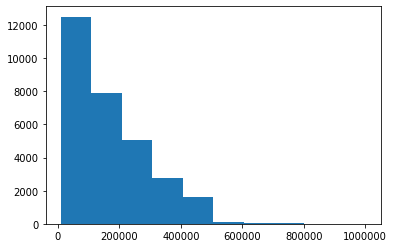

In [122]:
#visualize distributions
plt.hist(credit['LIMIT_BAL'])
plt.show()

In [123]:
credit['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

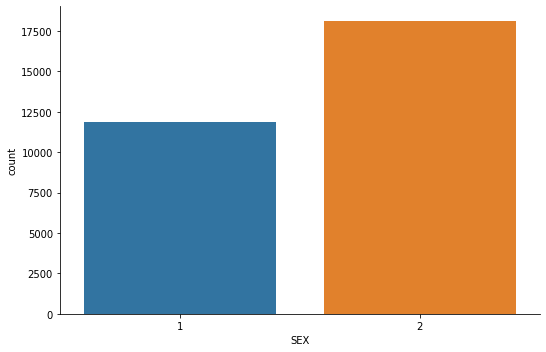

In [124]:
fg = sns.catplot('SEX', data=credit, kind='count', aspect=1.5)
fg.set_xlabels('SEX')

There are 1.5 more females in this dataset than males.

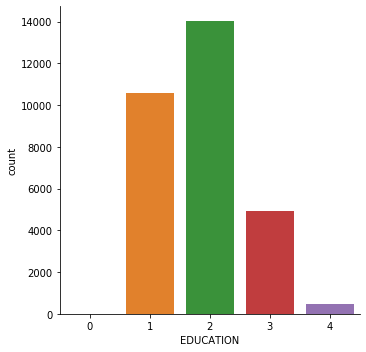

In [125]:
g = sns.catplot('EDUCATION', data=credit, kind='count', aspect=1)
g.set_xlabels('EDUCATION')

There are only 14 people in the '0' education category. The others are grouped into category 4, which is still small compared to the others.

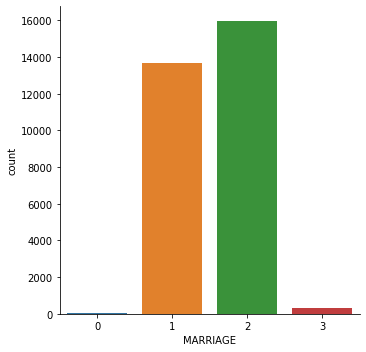

In [126]:
sns.catplot('MARRIAGE', data=credit, kind='count', aspect=1)

Vast majority of customers are either married (1) or single (2).

In [127]:
# Number of men and women in each of the education levels
credit.groupby(['SEX', 'EDUCATION'])['SEX'].count()

SEX  EDUCATION
1    0               8
     1            4354
     2            5374
     3            1990
     4             162
2    0               6
     1            6231
     2            8656
     3            2927
     4             292
Name: SEX, dtype: int64

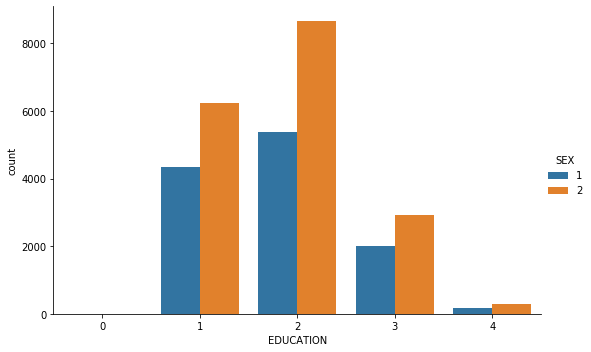

In [128]:
sns.catplot('EDUCATION', data=credit, hue='SEX', kind='count', aspect=1.5)

Distribution seems to fit the 1.5x females versus males. Females are higher in every education level and they trend similarly.

In [129]:
# Number of men and women in each of the education levels
credit.groupby(['EDUCATION', 'MARRIAGE'])['EDUCATION'].count()

EDUCATION  MARRIAGE
0          1              4
           2             10
1          0              4
           1           3722
           2           6809
           3             50
2          0              6
           1           6842
           2           7020
           3            162
3          0             44
           1           2861
           2           1909
           3            103
4          1            230
           2            216
           3              8
Name: EDUCATION, dtype: int64

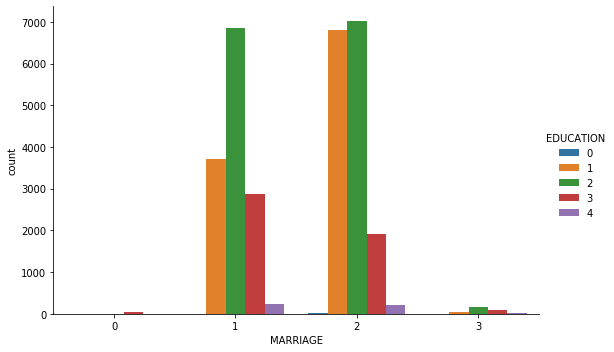

In [130]:
sns.catplot('MARRIAGE', data=credit, hue='EDUCATION', kind='count', aspect=1.5)

There are approx the same number of married (2) and single (1) people with university (2) education. There are much less married (2) people with graduate school (1) compared to single people.

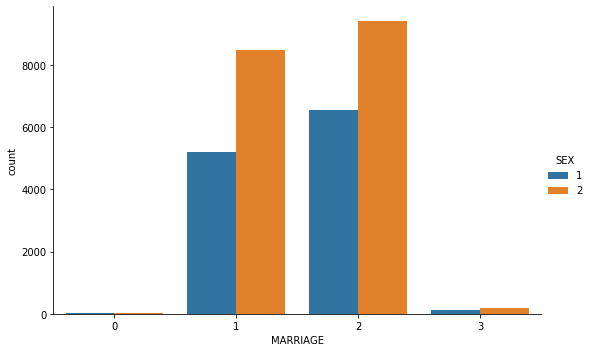

In [131]:
sns.catplot('MARRIAGE', data=credit, hue='SEX', kind='count', aspect=1.5)

TypeError: unorderable types: Interval() < float()

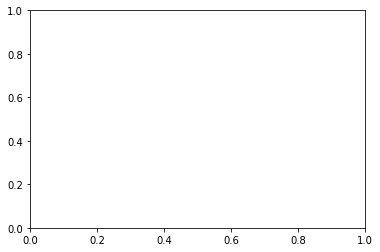

In [132]:
plt.hist(credit['AGE'], bins =4)
plt.xlabel("Age", fontsize=12)  
plt.ylabel("Count", fontsize=12)
plt.show()

In [ ]:
#distribution of age by marriage
fig = sns.FacetGrid(credit, hue='MARRIAGE', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Marriage')
fig.add_legend()

As expected, the majority of the single (2) customers are also the youngest.

In [ ]:
#distribution of age by education
fig2 = sns.FacetGrid(credit, hue='EDUCATION', aspect=4)
fig2.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig2.set(xlim=(0,oldest))
fig2.set(title='Distribution of Age Grouped by Education Level')
fig2.add_legend()

Also interesting that those with graduate schooling (1) also tend to be younger. More younger people have university (2)education vs the older population tend to have just high school (3) level.

In [ ]:
plt.hist(credit['PAY_0'])
plt.show()

There appear to be outliers in this group at the 7 month mark. Let's look closer at the actual values.

In [ ]:
credit['PAY_0'].value_counts()

In [ ]:
A = credit['PAY_0']
plt.boxplot(A,0,'gD')
plt.show()

Technically there are outlier values, but because they range from 2-8 and there is a significant number of them, they will not be removed. Logically, one would think delaying payment would be a significant factor on default risk.

In [ ]:
# Review if sex relates to payment delays
credit.groupby(['PAY_0', 'SEX'])['PAY_0'].count()

In [ ]:
sns.catplot('PAY_0', data=credit, hue='SEX', kind='count', aspect=1.5)

In [ ]:
sns.catplot('PAY_0', data=credit, hue='EDUCATION', kind='count', aspect=1.5)

In [ ]:
sns.catplot('PAY_0', data=credit, hue='MARRIAGE', kind='count', aspect=1.5)

In [ ]:
plt.hist(credit['PAY_2'])
plt.show()

In [ ]:
credit['PAY_2'].value_counts()

In [ ]:
plt.hist(credit['PAY_3'])
plt.show()

In [ ]:
credit['PAY_3'].value_counts()

In [ ]:
plt.hist(credit['PAY_4'])
plt.show()

In [ ]:
credit['PAY_4'].value_counts()

In [ ]:
plt.hist(credit['PAY_5'])
plt.show()

In [ ]:
credit['PAY_5'].value_counts()

In [ ]:
plt.hist(credit['PAY_6'])
plt.show()

In [ ]:
credit['PAY_6'].value_counts()

All of the payment columns show a highly left-skewed distribution, with 0 (no delay) being dominating group every time. Depending on model used will need to normalize later.

In [ ]:
plt.hist(credit['BILL_AMT1'],4)
print(credit.BILL_AMT1.min())
print(credit.BILL_AMT1.max())

In [ ]:
#who had the lowest bill?
credit[credit.BILL_AMT1 == -165580]

For first month tracked, a 37 year old, college educated, married male had the lowest bill (as a credit)

In [ ]:
#who had the highest bill?
credit[credit.BILL_AMT1 == 964511]

For the first month tracked, a 47 year old, graduate school, married female had the highest bill.

In [ ]:
plt.hist(credit['BILL_AMT6'],4)
print(credit.BILL_AMT6.min())
print(credit.BILL_AMT6.max())

In [ ]:
#are the same people the min/max for the sixth month?
credit[(credit.BILL_AMT6 == -339603) | (credit.BILL_AMT6 == 961664)]

The person with the highest bill is the same. New person for lowest bill (33 y/o single male).<br>
Interesting to note that person with lowest bill defaults, person with highest bill does not.

In [ ]:
plt.hist(credit['PAY_AMT1'],6)
print(credit.PAY_AMT1.min())
print(credit.PAY_AMT1.max())

In [ ]:
plt.hist(credit['PAY_AMT6'],6)
print(credit.PAY_AMT6.min())
print(credit.PAY_AMT6.max())

In [ ]:
#calculate ratio of last bill amount to limit balance
ratio = credit.PAY_AMT6 / credit.LIMIT_BAL

In [ ]:
plt.hist(ratio)
plt.show()

In [ ]:
plt.hist(credit['default'])
plt.show()

In [ ]:
# Linear plot of age vs. default rate
sns.lmplot('AGE', 'default', data=credit)

Not a large difference by age, although the older you are the very slightly higher chance that you'll default.

In [ ]:
# default vs. Age grouped by Sex
sns.lmplot('AGE', 'default', data=credit, col='SEX')

In [ ]:
# default vs. sex
sns.catplot('SEX', 'default', kind='violin', data=credit)

In [ ]:
# default vs. Age grouped by Sex
sns.catplot('EDUCATION', 'default', kind='violin', data=credit)

In [ ]:
credit.groupby(['EDUCATION', 'default'])['EDUCATION'].count()

Education level 3 has the highest proportion of clients that default.

In [ ]:
credit.groupby(['MARRIAGE', 'default'])['MARRIAGE'].count()

Overall, for each marriage group, there is a higher proportion of customers that do NOT default.

In [ ]:
#payment amount versus default
sns.lmplot('PAY_AMT1', 'default', data=credit)

The higher the payment amount, the lower the chance of default.

In [ ]:
#limit balance versus default
sns.lmplot('LIMIT_BAL', 'default', data=credit)

The higher the limit balance, the lower the chance of default

In [ ]:
#bill amount versus default
sns.lmplot('BILL_AMT1', 'default', data=credit)

In [ ]:
#bill amount versus default
sns.catplot('PAY_6', 'default', kind='violin', data=credit)

Even those customers that paid in full, didn't consume, or used revolving credit in the sixth month still had a small rate of default.

In [ ]:
#after EDA, change data types for modelling to categorical as needed
"""credit["SEX"] = credit["SEX"].astype('category')
credit["EDUCATION"] = credit["EDUCATION"].astype('category')
credit["MARRIAGE"] = credit["MARRIAGE"].astype('category')
credit["PAY_0"] = credit["PAY_0"].astype('category')
credit["PAY_2"] = credit["PAY_2"].astype('category')
credit["PAY_3"] = credit["PAY_3"].astype('category')
credit["PAY_4"] = credit["PAY_4"].astype('category')
credit["PAY_5"] = credit["PAY_5"].astype('category')
credit["PAY_6"] = credit["PAY_6"].astype('category')
credit["default"] = credit["default"].astype('category')

#save as new dataset"""
